<a href="https://colab.research.google.com/github/SwiftDusk77/ADS2002-bhal0021/blob/main/IntroductionCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to Convolution Neural Networks

In this notebook we introduce the important concepts for understanding basic convolution neural networks. In the following notebook we will show how these can be used for image classification.

## Contents
* Definition of a Convolution
* One-dimensional convolutions
* Two-dimensional convolutions
* Creating a CNN
* Exercises

## Definition of a Convolution

The main building block for image processing using neural networks are convolutional neural networks (CNNs or convnets). These work by learning local patterns using convolutional layers and then building up complex, global patterns by stacking these layers. Before discussing convnets we first need to briefly consider convolutions and what they do.

The simplest way to understand a convolution is as a filter. If you take the three-point average of a time-series or sequence, you are taking a convolution.

We will just consider one-dimensional convolutions first. There are two parts to the convolution. There is the filter or kernel and then there is the sequence that this is applied to. Typically the kernel is much shorter that the sequence. Assume we have a kernel of length $n$, denoted by ${\mathbf v} = (v_1, v_2, \dots , v_n)$ and we want to convolve this with a sequence of length $N$, given by ${\mathbf x} = (x_1, x_2, \dots , x_N)$. Assume that $n$ is odd and let $m=(n-1)/2$, then the convolution is defined as

$$ ({\mathbf x}*{\mathbf v})_i = \sum_{j=1}^n v_j x_{i+j-m-1}, \quad i = 1, \dots,N. $$

The subscript for $x$ in the summation ensures that the convolution is centred on $i$.

Let $n=3$, then $m=1$. Then you can see that the convolution at $i=1$ and $i=N$ uses $x_0$ and $x_{N+1}$ respectively. These values don't exist, hence either the convolution only is defined for $i=2,\dots, N-1$ or we need to introduce **padding** by adding $x_0 = x_{N+1} = 0$ to ${\mathbf x} = (x_1, x_2, \dots , x_N)$.

A useful way to conceptualize the convolution is that the kernel (which doesn't change) slides over the sequence, and at each point the dot product of the kernel and sequence gives the convolution. The convolution is the response of the sequence to the kernel.


## One-dimensional convolutions

We will consider some examples of convolutions. In the cell below a random sequence is created and we then take the three and five point average of this sequence by using a convolution. The argument `mode="valid"` means only take the convolution at valid points and don't use padding.

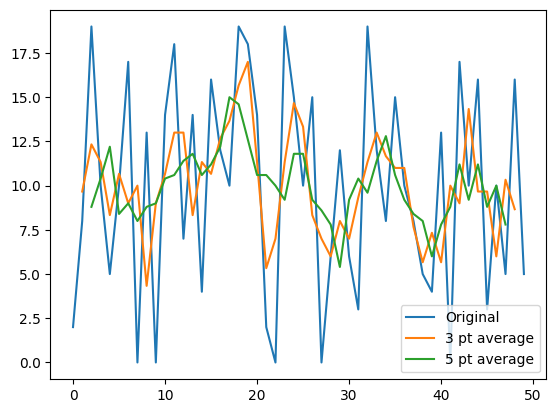

In [ ]:
from scipy import signal
import numpy as np
import matplotlib.pyplot as plt

nx = 50
ix = np.arange(nx)
filt3pt = 1./3.*np.array([1,1,1])
filt5pt = 1./5.*np.array([1,1,1,1,1])

x = np.random.randint(20, size=nx)
ave3pt = signal.convolve(filt3pt, x, mode="valid")
ave5pt = signal.convolve(filt5pt, x, mode="valid")

plt.plot(ix,x)
plt.plot(ix[1:nx-1],ave3pt)
plt.plot(ix[2:nx-2],ave5pt)
plt.legend(['Original', '3 pt average', '5 pt average']);

We could try different weights for the averages, for example by giving more weight to the centre point, but ensuring the weights sum to one.

However, convolutions are not limited to taking averages. We could also use them to approximate derivatives of sequences. Below we approximate the first and second derivative of the 5 point average that was previously created.

These convolutions tell us about patterns in the sequence, e.g., where it is rapidly changing or where the curvature is large.

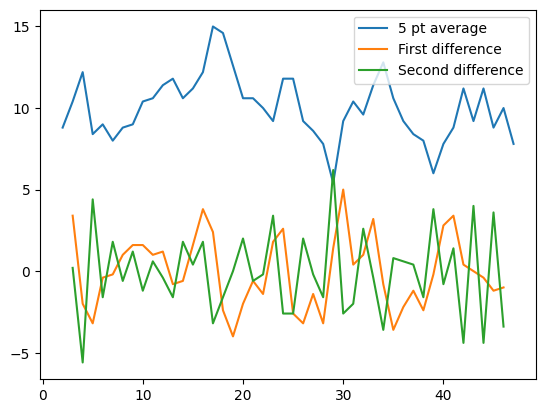

In [ ]:
filtd1 = np.array([1,0,-1])
filtd2 = np.array([1,-2,1])
x = np.random.randint(20, size=nx)
d1 = signal.convolve(filtd1, ave5pt, mode="valid")
d2 = signal.convolve(filtd2, ave5pt, mode="valid")

plt.plot(ix[2:nx-2],ave5pt)
plt.plot(ix[3:nx-3],d1)
plt.plot(ix[3:nx-3],d2)
plt.legend(['5 pt average', 'First difference', 'Second difference']);

Convolutions can also be used for `downsampling` or `pooling` a sequence. For example, if we want to reduce the size of a sequence. For these operations the convolution is typically even and we introduce the concept of a stride. Say we want to reduce the size of a sequence by a factor of 2. To do this we could take the average of consecutive points and then move the kernel two positions to perform the next calculations. The number of points that we move the kernel between each calculation is then known as the `stride`. This process is known as `average pooling`.

Below we apply average pooling to our random sequence in two steps. Where we create the array `downsample` the argument `[::2]` signifies go from the start to the finish, but only take every second value.

Size of original array is 50
Size of downsample is 25


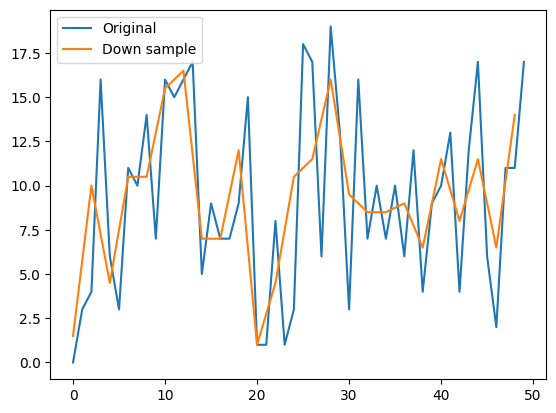

In [ ]:
filt2pt = 1./2.*np.array([1,1])

x = np.random.randint(20, size=nx)
ave2pt = signal.convolve(filt2pt, x, mode="valid")
downsample = ave2pt[::2]

print(f"Size of original array is {x.size}")
print(f"Size of downsample is {downsample.size}")

plt.plot(ix,x)
plt.plot(ix[::2],downsample)
plt.legend(['Original', 'Down sample']);

## Two-dimensional convolutions

We can now investigate the effect of convolutions on a two-dimensional image. The main difference is that the convolutions are also two-dimensional and they slide over every point in the image. The mathematics that we have covered is essentially the same.

We download a RGB (red, green blue) image of a stinkbug. This is a tensor (multi-dimensional array) which has width 375, depth 500 and three channels (one each for red, green and blue intensity). We will discuss channels later, but for the moment we convert this to a two-dimensional grayscale image and scale the intensity so that it lies in the range [0,1].

Shape of stinkbug array is (375, 500, 3)
Shape of grayscale image is (375, 500)
Minimum and maximum intensities are 0.0 and 0.851


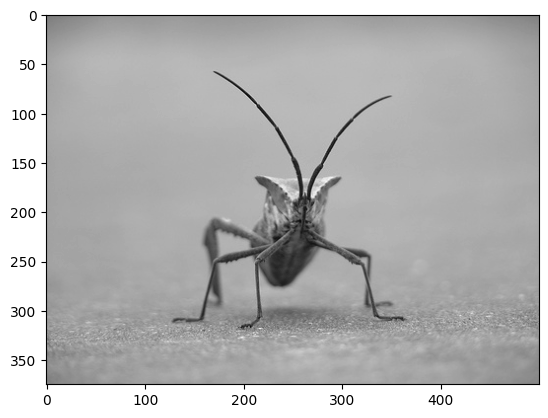

In [ ]:
import matplotlib.image as mpimg
from imageio.v2 import imread

# download image from the following url
url = "https://raw.githubusercontent.com/matplotlib/matplotlib/main/doc/_static/stinkbug.png"
img = imread(url)
print(f"Shape of stinkbug array is {img.shape}")
stinkbug = (0.2989*img[:,:,0] + 0.5870*img[:,:,1] + 0.1140*img[:,:,2])/255.
print(f"Shape of grayscale image is {stinkbug.shape}")
print(f"Minimum and maximum intensities are {stinkbug.min()} and {stinkbug.max().round(3)}")

plt.imshow(stinkbug, cmap='gray');

We will consider some `3x3` kernels here. The first is taking a 9 point average using all the surrounding points. Due to not using padding the size of the array reduces by two in each dimension. By taking the average the intensities reduce, and some of the features become slightly blurred. In particular, compare the antennae and legs in the two pictures.



Shape of averaged array is (373, 498)
Minimum and maximum intensities are 0.082 and 0.783


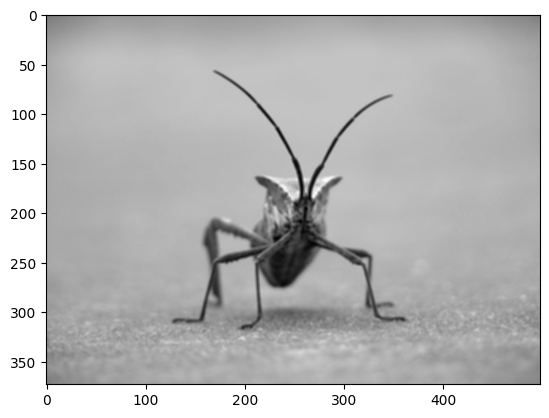

In [ ]:
# smoothing (average pooling)
filt = 1./9.*np.array([[1,1,1],[1,1,1],[1,1,1]])
c = signal.convolve(filt, stinkbug, mode="valid")
print(f"Shape of averaged array is {c.shape}")
print(f"Minimum and maximum intensities are {c.min().round(3)} and {c.max().round(3)}")
plt.imshow(c, cmap='gray');

This can be seen best by taking the diffence between the two images. This difference is most pronounced where there are rapid changes in the intensity. A technique such as this is useful in edge detection.

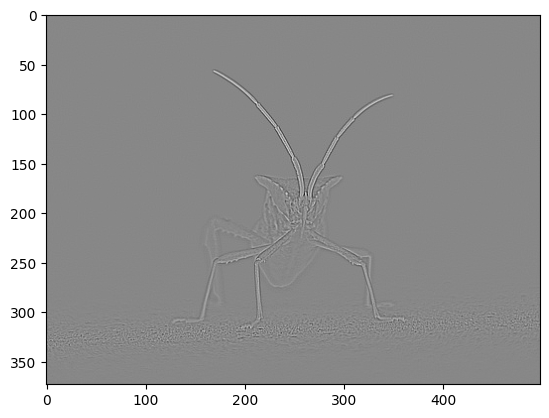

In [ ]:
diff = c-stinkbug[1:-1,1:-1]
plt.imshow(diff, cmap='gray');

Another method for edge detection is to take the Laplacian convolution of the image.

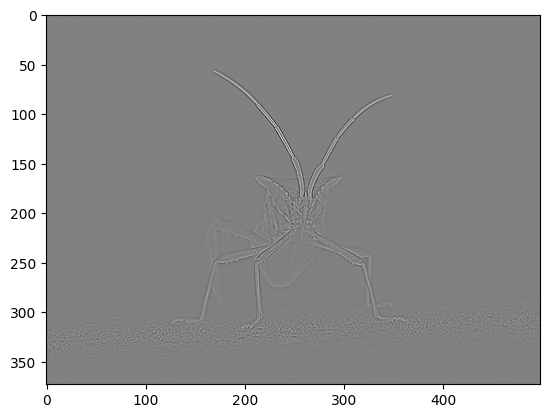

In [ ]:
# edge detection using the Laplacian
filt = np.array([[0,1,0],[1,-4,1],[0,1,0]])
c = signal.convolve(filt, stinkbug, mode="valid")
plt.imshow(c, cmap='gray');

Lastly, we can introduce `max pooling`, which is a similar process to the one-dimensional average pooling we discussed earlier, except that the maximum over the convolutional window is calculated rather than the average over that window. Max pooling is typically used in convnets rather than average pooling.

To use the `keras` implementation of two-dimensional max pooling we need to convert our image array to a four-dimensional tensor. The first dimension of the tensor is the batch size, which in this case is one, the next two dimensions are the width and depth of the array, and the final dimension is the number of channels, which in this case is again one.

Here we use a `2x2` kernel (`pool_size`) and strides of two in both dimensions. `padding="same"` signifies to include padding at the boundaries. In this case the size of the resultant array is exactly one-quarter of the original array.

The loss of resolution due to the down sampling can most clearly observed in the antennae and legs.

Shape of averaged array is (188, 250)


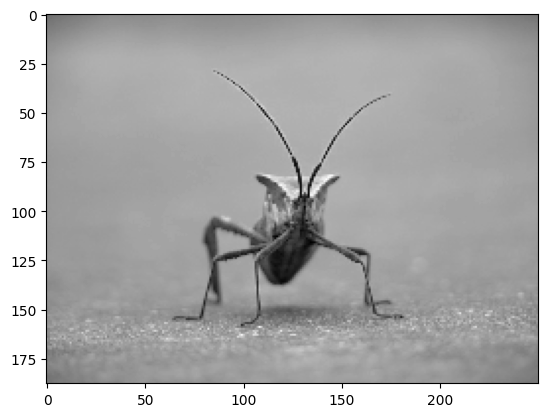

In [ ]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models

max_pool_2d = layers.MaxPooling2D(pool_size=(2, 2),
                                        strides=(2, 2), padding="same")

x = np.reshape(stinkbug, [1,stinkbug.shape[0],stinkbug.shape[1],1])
c = np.squeeze(max_pool_2d(x))
print(f"Shape of averaged array is {c.shape}")
plt.imshow(c, cmap='gray');

## Setting up a CNN

In the examples above the convolutions are taken in one and two dimensions. However, for images these convolutions are typically performed over three dimensions, corresponding to the width, depth and number of channels. Consider if the input image has width, depth and three colour channels (R, G and B). Then the convolution will be performed over the three dimensions, where the size of the kernel in the third dimension is equal to the number of channels. So the kernel slides over each spatial position, but is the same size as the number of channels. Again we have already seen an example of this when we converted the stinkbug image from RGB to grayscale. In this case the size of the kernel is `1x1x3`. Note a `1x1` kernel in two-dimensions does nothing apart from uniformly rescaling the intensity.

The example below shows input data with 3 channels and output data with 10 channels. Therefore, the convolution will have 10 kernels each with 3 channels. This is followed by a max pooling layer which reduces the data from `128x128` to `64x64`, but doesn't effect the number of channels.



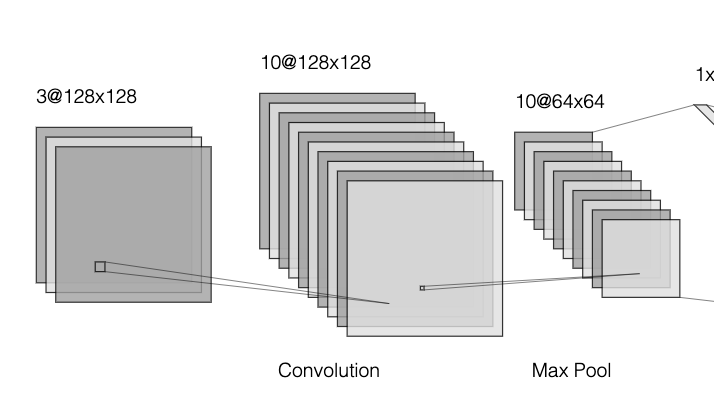

Max pooling is combined with convolutions to reduce the computational load and the number of parameters in the neural network. As we proceed deeper into a neural network typically the width and depth of the images decreases using max pooling, but the number of channels increases using convolutions. So what is occuring is that we lose spatial information, but increase the pattern information.

The final building block of a basic convnet are dense layers. These convert the multi-dimensional information to a one-dimensional array. This one-dimensional array can then pass through standard neural network layers and be processed for classification and regression. Regularization techniques such as dropout can also be added at this stage.

Below we show a simple convnet which could be used for image classification. The steps in this network are:
* Layer 1: Images of dimension `128x128` and with three channels are input to a convolution layer and the output are images of the same dimension, but now with 8 channels. Therefore there will be 8 kernels each with size `3x3x3`.
* Layer 2: The output of Layer 1 is now passed through a max-pooling layer which reduces the dimensions to `64x64`, but leaves the number of channels unchanged. The kernels are two-dimensional with size `2x2` and strides of two in both dimensions.
* Layer 3: The output of Layer 2 is passed to a convolution layer, for which the output are images with the same dimension, but now with 16 channels. Therefore there will be 16 kernels each with size `3x3x8`. The combination of Layer 2 and Layer 3 reduces the spatial dimensions, but increases the number of channels.
* Layer 4: The output of Layer 3 is passed through a max-pooling layer with the same parameters as Layer 2. This reduces the spatial dimension from `64x64` to `32x32`.
* Layer 5: The output of Layer 4 is flattened into a one-dimensional vector of length `16384=32x32x16` and passed to a dense layer with 128 nodes. The output of this is a vector of length 128.
* Layer 6: The output of Layer 5 is passed to a softmax layer which classifies this into 10 categories. The loss function is then calculated from these categories.



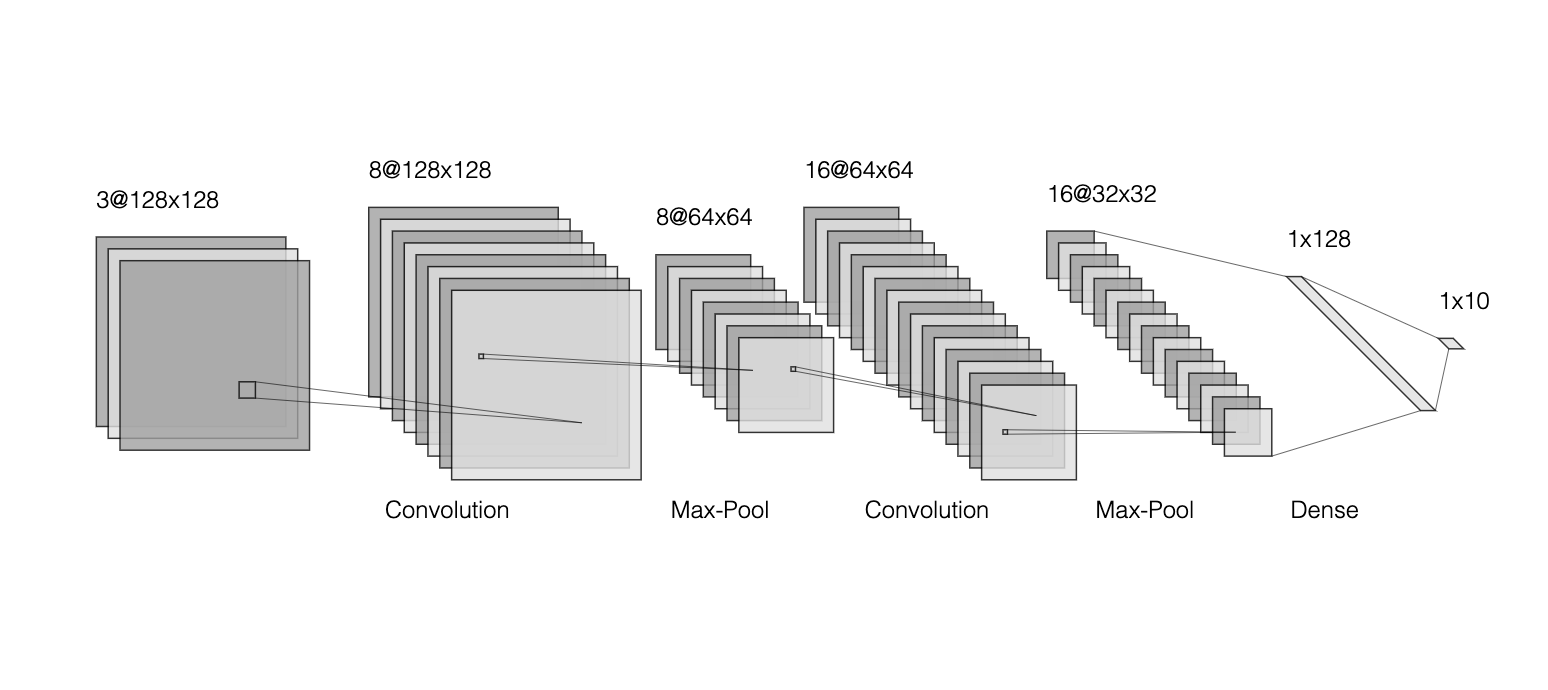

The convolution layers are typically combined with an activation function, which introduces nonlinearity into the convnet. Without nonlinearity the network is only linear and the utility is very limited.

In the above example we have assumed that padding is used in the convolution and max-pooling layers. If padding is not used, then in general the output dimensions will be reduced by one in both directions.

The above network can be set up with the `Sequential` method and the [Conv2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D) and [MaxPooling2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D) layers. Here we specify the input image size, though this is usually calculated from the input data. For the rest of the layers this is calculated automatically. We also do not need to specify the batch size as this will be calculated as part of the model compilation.


In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(8, (3, 3), activation='relu', input_shape=(128, 128, 3), padding="same"))
model.add(layers.MaxPooling2D((2, 2), padding="same"))
model.add(layers.Conv2D(16, (3, 3), activation='relu', padding="same"))
model.add(layers.MaxPooling2D((2, 2), padding="same"))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 128, 128, 8)         │             224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 64, 64, 8)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 64, 64, 16)          │           1,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 32, 32, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 16384)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       2,097,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,099,962 (8.01 MB)

 Trainable params: 2,099,962 (8.01 MB)

 Non-trainable params: 0 (0.00 B)

## Exercises

### Exercise 1 (5 marks)

Set up convolutions which take a uniform 7 point average of the stinkbug image in the width and the height direction respectively. Hints: the kernels only need to be one-dimensional row or column vectors and `T` will take the transpose of a numpy array.

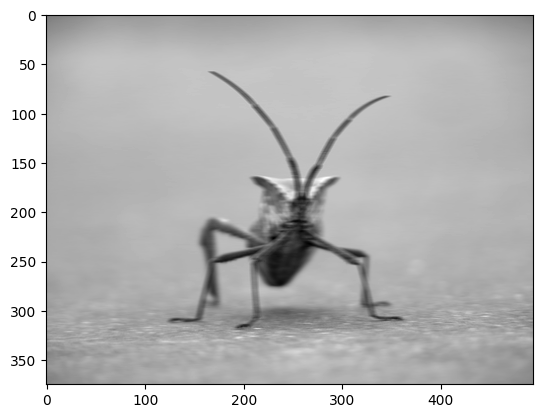

In [ ]:
seven_conx = 1./7.*np.array([[1,1,1,1,1,1,1]])
c = signal.convolve(stinkbug, seven_conx, mode="valid")
plt.imshow(c, cmap='gray');

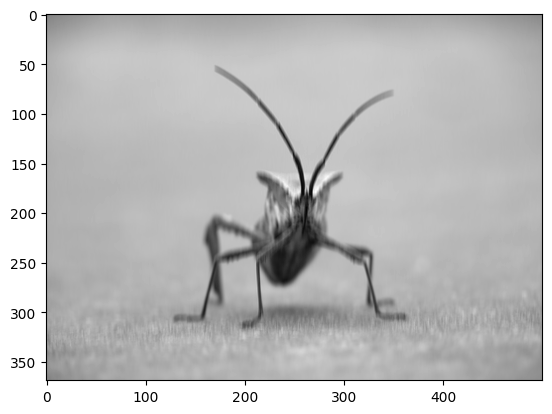

In [ ]:
seven_cony = 1./7.*np.array([[1,1,1,1,1,1,1]]).T
c = signal.convolve(stinkbug, seven_cony, mode="valid")
plt.imshow(c, cmap='gray');

## Exercise 2 (5 marks)

Create a convolution neural network for the binary classification of grayscale images of size `32x32`. Your network should have the following layers:
* Convolution layer with 16 filters.
* Max pooling layer.
* Convolution layer with 32 filters.
* Max pooling layer.
* Dense layer with 256 nodes.
* Dense layer with 128 nodes.
* Classification layer.

Your network should not use padding and should use the ReLU activation function.

How many trainable parameters does this network have?

In [ ]:
 model = models.Sequential()
model.add(layers.Conv2D(16, (3, 3), activation='relu', input_shape=(32, 32, 1), padding="valid"))
model.add(layers.MaxPooling2D((2, 2), padding="same"))
model.add(layers.Conv2D(32, (3, 3), activation='relu', padding="valid"))
model.add(layers.MaxPooling2D((2, 2), padding="same"))
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(2, activation='softmax'))
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 30, 30, 16)          │             160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 15, 15, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 13, 13, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 7, 7, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 1568)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │         401,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 439,618 (1.68 MB)

 Trainable params: 439,618 (1.68 MB)

 Non-trainable params: 0 (0.00 B)

Trainable parameters: 439,618